In [1]:
import torchquantum as tq
import torchquantum.functional as tqf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random

from torchquantum.dataset import MNIST
from torch.optim.lr_scheduler import CosineAnnealingLR


from torchquantum.encoding import encoder_op_list_name_dict
from torchquantum.layer import U3CU3Layer0

In [ ]:
class QuanvFilter(tq.QuantumModule):
    """A single quantum convolutional filter (quanvolutional layer)."""
    def __init__(self, n_qubits=4):
        super().__init__()
        self.n_wires = n_qubits  # number of qubits in the circuit (e.g., 4)
        self.arch = {'n_wires': self.n_wires, 'n_blocks': 5, 'n_layers_per_block': 2}
        self.q_layer = U3CU3Layer0(self.arch)
        self.measure = tq.MeasureAll(tq.PauliZ)  # measure all qubits in Z-basis
        self.phase_enc = tq.PhaseEncoder(func = tqf.ry)

    def forward(self, patch_values):
        """
        patch_values: Tensor of shape (batch, n_qubits) with normalized pixel values for one patch.
        Returns: Tensor of shape (batch,) with one scalar feature per patch (quantum pooled output).
        """
        bsz = patch_values.shape[0]
        # Initialize a quantum device with n_wires qubits for each sample in the batch
        qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz, device=patch_values.device)

        # Use rotation around Y-axis proportional to the pixel value
        self.phase_enc(qdev, patch_values*torch.pi)
        self.q_layer(qdev)

        # Measure all qubits to get classical outputs (expectation values in Z-basis)
        meas = self.measure(qdev)  # shape: (batch, n_qubits)
        # Quantum pooling: aggregate qubit measurements to a single value (here we take the average)
        pooled_output = meas.mean(dim=1)  # shape: (batch,)
        return pooled_output


class QuanvolutionalModel(tq.QuantumModule):
    """Quantum convolutional model using quanvolutional filters for feature extraction."""
    def __init__(self, n_filters=4, patch_size=2):
        super().__init__()
        self.patch_size = patch_size
        self.n_filters = n_filters
        # Initialize multiple quantum filters
        self.quantum_filters = tq.QuantumModuleList([QuanvFilter(n_qubits=patch_size*patch_size) 
                                              for _ in range(n_filters)])
        self.stride = patch_size  # no overlap
        self.out_size = 28 // patch_size  # 28 is divisible by patch_size in this setup

        self.classifier = nn.Linear(n_filters * self.out_size * self.out_size, 10)

    def forward(self, x):
        # x: input image tensor of shape (batch, 1, 28, 28)
        bsz = x.shape[0]
        # Unfold the image into patches of size (patch_size x patch_size)
        patches = F.unfold(x, kernel_size=self.patch_size, stride=self.stride)
        # F.unfold returns shape (batch, patch_size*patch_size, num_patches_per_image)
        # Transpose to shape (batch, num_patches, patch_size*patch_size) for easier iteration
        patches = patches.transpose(1, 2)  # now (batch, num_patches, patch_elems)
        b, num_patches, patch_elems = patches.shape 
        # Reshape to combine batch and patch dims for processing through quantum filters
        patches = patches.reshape(b * num_patches, patch_elems)

        filter_outputs = []
        for qf in self.quantum_filters:
            out = qf(patches)  # shape: (b * num_patches,)
            out = out.view(b, num_patches)
            filter_outputs.append(out)

        quantum_feature_maps = torch.stack(filter_outputs, dim=1)
        quantum_feature_maps = quantum_feature_maps.view(b, self.n_filters, self.out_size, self.out_size)
        features = quantum_feature_maps.view(b, -1)  # shape: (batch, n_filters * out_size * out_size)
        logits = self.classifier(features)  # output shape: (batch, 10)
        return logits.to(x.device)


In [ ]:
n_wires = 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_epochs = 10
lossfn = torch.nn.CrossEntropyLoss()

In [4]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # ensures data in [0, 1]
])

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

dataset = MNIST(
    root="./mnist_data",
    train_valid_split_ratio=[0.9, 0.1],
    # digits_of_interest=[0,1,2,3],
    n_test_samples=500,
    n_train_samples=2000,
)
dataflow = dict()

for split in dataset:
    sampler = torch.utils.data.RandomSampler(dataset[split])
    dataflow[split] = torch.utils.data.DataLoader(
        dataset[split],
        batch_size=10,
        sampler=sampler,
        num_workers=8,
        pin_memory=True,
    )
train_loader = dataflow['train']
test_loader = dataflow['test']
valid_loader = dataflow['valid']

[2025-05-14 15:07:57.590] Only use the front 2000 images as TRAIN set.
[2025-05-14 15:07:57.642] Only use the front 500 images as TEST set.


In [5]:
def train(dataflow, model, device, optimizer):
    for feed_dict in dataflow:
        # print(feed_dict)
        inputs = feed_dict["image"].to(device)
        targets = feed_dict["digit"].to(device)

        outputs = model(inputs)
        loss = lossfn(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"loss: {loss.item()}", end="\r")

def valid_test(dataflow, model, device):
    target_all = []
    output_all = []
    with torch.no_grad():
        for feed_dict in dataflow:
            inputs = feed_dict["image"].to(device)
            targets = feed_dict["digit"].to(device)

            outputs = model(inputs)

            target_all.append(targets)
            output_all.append(outputs)
        target_all = torch.cat(target_all, dim=0)
        output_all = torch.cat(output_all, dim=0)

    _, indices = output_all.topk(1, dim=1)
    masks = indices.eq(target_all.view(-1, 1).expand_as(indices))
    size = target_all.shape[0]
    corrects = masks.sum().item()
    accuracy = corrects / size
    loss = lossfn(output_all, target_all).item()

    print(f"Valid test set accuracy: {accuracy}")
    print(f"Valid test set loss: {loss}")

    return accuracy, loss

In [13]:
# Instantiate the quantum model

quanv_model = QuanvolutionalModel(n_filters=4, patch_size=2).to(device)
optimizer = optim.Adam(quanv_model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=10)
accu_list4 = []
loss_list4 = []
for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(train_loader, quanv_model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(valid_loader, quanv_model, device)
    accu_list4.append(accu)
    loss_list4.append(loss)
    scheduler.step()
#     torch.save(qmodel3.state_dict(), f"./model/qmodel3/qmodel3_epoch_{epoch}.pth")
#     torch.save({
#     "accuracy": accu_list4,
#     "loss":     loss_list4
# }, "./model/qmodel3/metrics.pth")

Epoch 1:
0.005 0.60287767648696966
Valid test set accuracy: 0.8133333333333334
Valid test set loss: 0.5853269696235657
Epoch 2:
0.00487764129073788468374
Valid test set accuracy: 0.8571666666666666
Valid test set loss: 0.47269558906555176
Epoch 3:
0.004522542485937368531166
Valid test set accuracy: 0.8635
Valid test set loss: 0.4347284734249115
Epoch 4:
0.003969463130731183948744
Valid test set accuracy: 0.8541666666666666
Valid test set loss: 0.45682674646377563
Epoch 5:
0.003272542485937368762986
Valid test set accuracy: 0.8711666666666666
Valid test set loss: 0.40714678168296814
Epoch 6:
0.00250.053194753825664523
Valid test set accuracy: 0.8806666666666667
Valid test set loss: 0.38537919521331787
Epoch 7:
0.001727457514062631686856
Valid test set accuracy: 0.8773333333333333
Valid test set loss: 0.38021302223205566
Epoch 8:
0.001030536869268817457384
Valid test set accuracy: 0.8806666666666667
Valid test set loss: 0.38474610447883606
Epoch 9:
0.000477457514062631632049
Valid test s

In [ ]:
torch.save(quanv_model.state_dict(), f"./model/test2/quanv_model.pth")
torch.save({
"accuracy": accu_list4,
"loss":     loss_list4
}, "./model/test2/quanv_model_metrics.pth")

In [10]:
class Model_without_filters(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv = torch.nn.Conv2d(in_channels= 1, out_channels= 4,kernel_size=10,stride=2,padding=1,)
        self.linear = torch.nn.Linear(4*14*14, 10)
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = self.linear(x)

        return x

model_without_filters = Model_without_filters().to(device)
optimizer = optim.Adam(model_without_filters.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
accu_list2 = []
loss_list2 = []

for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(train_loader, model_without_filters, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(valid_loader, model_without_filters, device)
    accu_list2.append(accu)
    loss_list2.append(loss)

    scheduler.step()

Epoch 1:
0.005 0.401081800460815435
Valid test set accuracy: 0.795
Valid test set loss: 0.7343968749046326
Epoch 2:
0.004877641290737884615847
Valid test set accuracy: 0.8498333333333333
Valid test set loss: 0.5733386278152466
Epoch 3:
0.0045225424859373685489277
Valid test set accuracy: 0.8301666666666667
Valid test set loss: 0.6787992715835571
Epoch 4:
0.0039694631307311833367368
Valid test set accuracy: 0.8693333333333333
Valid test set loss: 0.5576021671295166
Epoch 5:
0.0032725424859373687360749
Valid test set accuracy: 0.8741666666666666
Valid test set loss: 0.5175167918205261
Epoch 6:
0.00250.0291484855115413675
Valid test set accuracy: 0.8756666666666667
Valid test set loss: 0.5006267428398132
Epoch 7:
0.0017274575140626316304782
Valid test set accuracy: 0.8713333333333333
Valid test set loss: 0.5111255049705505
Epoch 8:
0.0010305368692688174797965
Valid test set accuracy: 0.8728333333333333
Valid test set loss: 0.5096449255943298
Epoch 9:
0.0004774575140626316345365
Valid test

In [ ]:
torch.save(model_without_filters.state_dict(), f"./model/test2/model_without_filters.pth")
torch.save({
"accuracy": accu_list2,
"loss":     loss_list2
}, "./model/test2/model_without_filters_metrics.pth")

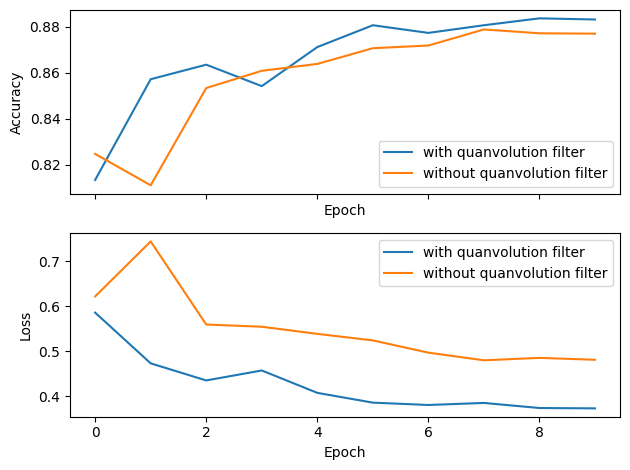

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(accu_list4, label="with quanvolution filter")
ax1.plot(accu_list2, label="without quanvolution filter")
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0.6, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(loss_list4, label="with quanvolution filter")
ax2.plot(loss_list2, label="without quanvolution filter")
ax2.set_ylabel("Loss")
# ax2.set_ylim([0, 2])
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [35]:
# ─────────────────────────────────────────────────────────────────────────────
# 1) QC→C: quanvolutional feature extractor + classical CNN head
# ─────────────────────────────────────────────────────────────────────────────
class QC_C_Model(nn.Module):
    class QuanvFilter(tq.QuantumModule):
        """A single quantum convolutional filter (quanvolutional layer)."""
        def __init__(self, n_qubits=4):
            super().__init__()
            self.n_wires = n_qubits  # number of qubits in the circuit (e.g., 4)
            self.arch = {'n_wires': self.n_wires, 'n_blocks': 5, 'n_layers_per_block': 2}
            self.q_layer = U3CU3Layer0(self.arch)
            self.measure = tq.MeasureAll(tq.PauliZ)  # measure all qubits in Z-basis
            self.phase_enc = tq.PhaseEncoder(func = tqf.ry)
            
        def forward(self, patch_values):
            bsz = patch_values.shape[0]
            # Initialize a quantum device with n_wires qubits for each sample in the batch
            qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz, device=patch_values.device)
            self.phase_enc(qdev, patch_values*torch.pi)
            self.q_layer(qdev)

            # Measure all qubits to get classical outputs (expectation values in Z-basis)
            meas = self.measure(qdev)  # shape: (batch, n_qubits)
            # Quantum pooling: aggregate qubit measurements to a single value (here we take the average)
            pooled_output = meas.mean(dim=1)  # shape: (batch,)
            return pooled_output
        
    def __init__(self, n_filters: int = 8, patch_size: int = 2):
        super().__init__()
        self.patch_size = patch_size
        self.stride = patch_size
        self.out_size = 28 // patch_size
        n_qubits = patch_size * patch_size
        self.n_filters = n_filters

        # build a bank of quanvolutional filters
        self.qfilters = nn.ModuleList([
            self.QuanvFilter(n_qubits=patch_size*patch_size) for _ in range(self.n_filters)
        ])

        # small classical CNN head over the n_filters feature maps
        # feature maps shape: (N, n_filters, out_size, out_size)
        self.classical_head = nn.Sequential(
            nn.Conv2d(self.n_filters, 16, kernel_size=3, padding=1),  # -> (16, out_size, out_size)
            nn.ReLU(),
            nn.MaxPool2d(2),                                     # -> (16, out_size/2, out_size/2)
            nn.Flatten(),
            nn.Linear(16 * (self.out_size//2) * (self.out_size//2), 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        N = x.size(0)
        # 1) unfold into non-overlapping patches
        patches = F.unfold(x,kernel_size=self.patch_size,stride=self.stride)
        # patches: (N, patch_size*patch_size, num_patches)
        patches = patches.transpose(1,2).flatten(0,1)
        # now (N*num_patches, patch_elems)

        # apply each quanvolutional filter over all patches at once
        feats = []
        for module_list in self.qfilters:
            # module_list is a QuantumModuleList of [encoder, variational, measure]
            pooled = module_list(patches * torch.pi)       # encode + ansatz + measure
            pooled = pooled.view(N, -1)
            feats.append(pooled)

        # stack into (N, n_filters, num_patches)
        qmaps = torch.stack(feats, dim=1)
        # reshape into (N, n_filters, out_size, out_size)
        qmaps = qmaps.view(N, len(self.qfilters), self.out_size, self.out_size)

        # 2) classical CNN head
        return self.classical_head(qmaps)

In [ ]:
QCmodel = QC_C_Model().to(device)
optimizer = optim.Adam(QCmodel.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
accu_list3 = []
loss_list3 = []

for epoch in range(1, n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(train_loader, QCmodel, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(valid_loader,QCmodel, device)
    accu_list3.append(accu)
    loss_list3.append(loss)

    scheduler.step()


Epoch 1:
0.005 0.73141729831695564
Valid test set accuracy: 0.7341666666666666
Valid test set loss: 0.7826728224754333
Epoch 2:
0.00487764129073788465877
Valid test set accuracy: 0.8148333333333333
Valid test set loss: 0.5694285035133362
Epoch 3:
0.004522542485937368580345
Valid test set accuracy: 0.8445
Valid test set loss: 0.4811716675758362
Epoch 4:
0.0039694631307311830765148
Valid test set accuracy: 0.8511666666666666
Valid test set loss: 0.49008849263191223
Epoch 5:
0.0032725424859373687824982
Valid test set accuracy: 0.8583333333333333
Valid test set loss: 0.5202012062072754
Epoch 6:
0.00250.1555594652891159865


In [47]:
torch.save(QCmodel.state_dict(), f"./model/test2/QCmodel.pth")
torch.save({
"accuracy": accu_list3,
"loss":     loss_list3
}, "./model/test2/QCmodel_metrics.pth")

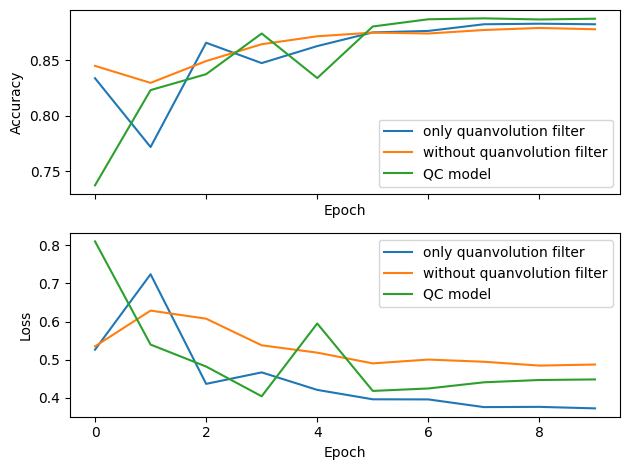

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(accu_list4, label="only quanvolution filter")
ax1.plot(accu_list2, label="without quanvolution filter")
ax1.plot(accu_list3, label="QC model")
ax1.set_ylabel("Accuracy")
# ax1.set_ylim([0.6, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(loss_list4, label="only quanvolution filter")
ax2.plot(loss_list2, label="without quanvolution filter")
ax2.plot(loss_list3, label="QC model")
ax2.set_ylabel("Loss")
# ax2.set_ylim([0, 2])
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [ ]:
# FashionMNIST

import torch
from torch.utils.data import DataLoader, RandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

# 1) Wrap FashionMNIST so it returns the same dict structure
class DictFashionMNIST(FashionMNIST):
    def __getitem__(self, idx):
        img, label = super().__getitem__(idx)
        return {"image": img, "digit": label}

transform = Compose([
    Resize(28),
    ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),  # if you want to normalize
])

train_ds = DictFashionMNIST(
    root="./data",
    train=True,       # <-- training split
    download=True,
    transform=transform
)
test_ds  = DictFashionMNIST(
    root="./data",
    train=False,      # <-- test split
    download=True,
    transform=transform
)

batch_size = 10
fashion_train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    sampler=RandomSampler(train_ds, num_samples=1000, replacement=False),
    num_workers=2,
    pin_memory=True
)

fashion_test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    sampler=RandomSampler(test_ds,  num_samples=200, replacement=False),
    num_workers=2,
    pin_memory=True
)

In [ ]:
fashion_mnist_quanv_model = QuanvolutionalModel(n_filters=8, patch_size=2).to(device)
optimizer = torch.optim.Adam(fashion_mnist_quanv_model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=2*n_epochs)
accu_list6 = []
loss_list6 = []

for epoch in range(1, 21):
    # train
    print(f"Epoch {epoch}:")    
    train(fashion_train_loader, fashion_mnist_quanv_model, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid 
    accu, loss = valid_test(fashion_test_loader, fashion_mnist_quanv_model, device)
    accu_list6.append(accu)
    loss_list6.append(loss)

    scheduler.step()



Epoch 1:
0.005 0.74222868680953987
Valid test set accuracy: 0.79
Valid test set loss: 0.5592408180236816
Epoch 2:
0.00496922085148784451485
Valid test set accuracy: 0.775
Valid test set loss: 0.6016829013824463
Epoch 3:
0.00487764129073788467335
Valid test set accuracy: 0.785
Valid test set loss: 0.5928456783294678
Epoch 4:
0.004727516310470927282164
Valid test set accuracy: 0.78
Valid test set loss: 0.5783983469009399
Epoch 5:
0.004522542485937369705666
Valid test set accuracy: 0.84
Valid test set loss: 0.5125445127487183
Epoch 6:
0.00426776695296636964716
Valid test set accuracy: 0.855
Valid test set loss: 0.45569273829460144
Epoch 7:
0.003969463130731183981974
Valid test set accuracy: 0.815
Valid test set loss: 0.4682910442352295
Epoch 8:
0.00363497624934886730465
Valid test set accuracy: 0.845
Valid test set loss: 0.4201436936855316
Epoch 9:
0.003272542485937369346445
Valid test set accuracy: 0.86
Valid test set loss: 0.45377808809280396
Epoch 10:
0.002891086162600577724224
Valid t

In [ ]:
fashion_model_without_filters = Model_without_filters().to(device)
optimizer = optim.Adam(fashion_model_without_filters.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=2*n_epochs)
accu_list8 = []
loss_list8 = []

for epoch in range(1, 2*n_epochs + 1):
    # train
    print(f"Epoch {epoch}:")
    train(fashion_train_loader, fashion_model_without_filters, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid
    accu, loss = valid_test(fashion_test_loader, fashion_model_without_filters, device)
    accu_list8.append(accu)
    loss_list8.append(loss)

    scheduler.step()

Epoch 1:
0.005 0.33972883224487305
Valid test set accuracy: 0.745
Valid test set loss: 0.7414247989654541
Epoch 2:
0.00496922085148784451636
Valid test set accuracy: 0.78
Valid test set loss: 0.6375653147697449
Epoch 3:
0.00487764129073788460476
Valid test set accuracy: 0.7
Valid test set loss: 0.7435262799263
Epoch 4:
0.00472751631047092818123
Valid test set accuracy: 0.79
Valid test set loss: 0.6032609343528748
Epoch 5:
0.00452254248593736995464
Valid test set accuracy: 0.73
Valid test set loss: 0.6592835187911987
Epoch 6:
0.00426776695296636922717
Valid test set accuracy: 0.8
Valid test set loss: 0.49259617924690247
Epoch 7:
0.00396946313073118393378
Valid test set accuracy: 0.74
Valid test set loss: 0.8390256762504578
Epoch 8:
0.00363497624934886735956
Valid test set accuracy: 0.78
Valid test set loss: 0.6433686017990112
Epoch 9:
0.00327254248593736957528
Valid test set accuracy: 0.82
Valid test set loss: 0.5813660621643066
Epoch 10:
0.00289108616260057777836
Valid test set accurac

In [ ]:
fashion_mnist_quanv_model2 = QC_C_Model(n_filters=8, patch_size=2).to(device)
optimizer = torch.optim.Adam(fashion_mnist_quanv_model2.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = CosineAnnealingLR(optimizer, T_max=20)
accu_list7 = []
loss_list7 = []

for epoch in range(1, 21):
    # train
    print(f"Epoch {epoch}:")    
    train(fashion_train_loader, fashion_mnist_quanv_model2, device, optimizer)
    print(optimizer.param_groups[0]['lr'])

    # valid 
    accu, loss = valid_test(fashion_test_loader, fashion_mnist_quanv_model2, device)
    accu_list7.append(accu)
    loss_list7.append(loss)

    scheduler.step()

Epoch 1:
0.005 1.2135269641876226
Valid test set accuracy: 0.685
Valid test set loss: 0.7606114149093628
Epoch 2:
0.00496922085148784458824
Valid test set accuracy: 0.67
Valid test set loss: 0.9328935146331787
Epoch 3:
0.00487764129073788462595
Valid test set accuracy: 0.69
Valid test set loss: 0.8145826458930969
Epoch 4:
0.00472751631047092733033
Valid test set accuracy: 0.775
Valid test set loss: 0.6996432542800903
Epoch 5:
0.00452254248593736973857
Valid test set accuracy: 0.805
Valid test set loss: 0.5466111898422241
Epoch 6:
0.00426776695296636919184
Valid test set accuracy: 0.815
Valid test set loss: 0.5331670641899109
Epoch 7:
0.00396946313073118395175
Valid test set accuracy: 0.805
Valid test set loss: 0.5677731037139893
Epoch 8:
0.00363497624934886730354
Valid test set accuracy: 0.825
Valid test set loss: 0.4583708941936493
Epoch 9:
0.003272542485937369019965
Valid test set accuracy: 0.82
Valid test set loss: 0.532986581325531
Epoch 10:
0.002891086162600577720756
Valid test se

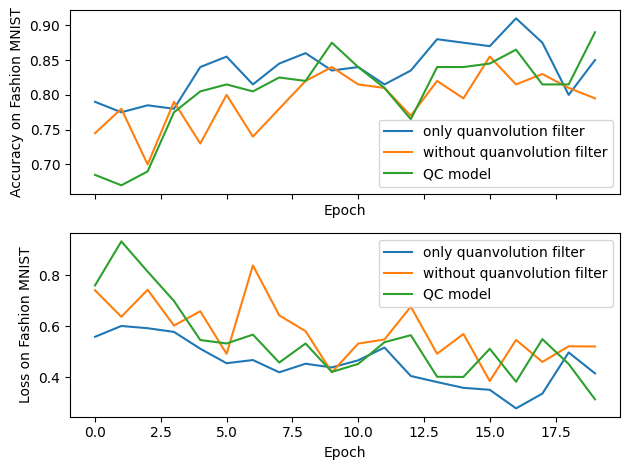

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(accu_list6, label="only quanvolution filter")
ax1.plot(accu_list8, label="without quanvolution filter")
ax1.plot(accu_list7, label="QC model")
ax1.set_ylabel("Accuracy on Fashion MNIST")
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(loss_list6, label="only quanvolution filter")
ax2.plot(loss_list8, label="without quanvolution filter")
ax2.plot(loss_list7, label="QC model")
ax2.set_ylabel("Loss on Fashion MNIST")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

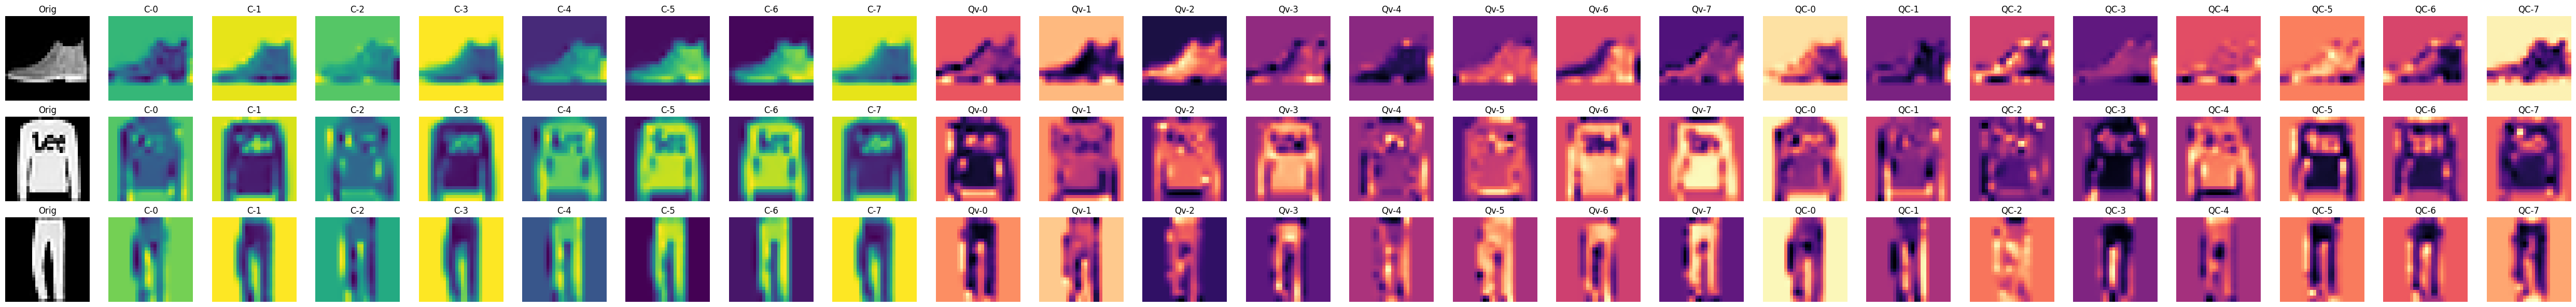

In [ ]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Subset

class ClassicalPatchCNN(torch.nn.Module):
    def __init__(self, n_filters, patch_size):
        super().__init__()
        self.conv = torch.nn.Conv2d(1, n_filters,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    bias=False)
    def forward(self, x):
        return self.conv(x)

classical_patch_cnn = ClassicalPatchCNN(4, 2).to(device).eval()


transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),        # yields [0,1]
])
full_test = FashionMNIST(root="./data", train=False, download=True, transform=transform)
# just take first 12 images for quick display
subset = Subset(full_test, list(range(12)))
loader = DataLoader(subset, batch_size=4, shuffle=False)

n_filters  = 8
patch_size = 2

quanv_model   = QuanvolutionalModel(n_filters=n_filters, patch_size=patch_size)\
                   .to(device).eval()
qc_model      = QC_C_Model(n_filters=n_filters, patch_size=patch_size)\
                   .to(device).eval()
classical_cnn = ClassicalPatchCNN(n_filters=n_filters, patch_size=patch_size)\
                   .to(device).eval()

def get_classical_maps(x):
    # x: (B,1,28,28)
    return classical_cnn.conv(x)  # → (B, n_filters, 14, 14)

def get_quanv_maps_batch(x, model):
    # x: (B,1,28,28)
    p, B = model.patch_size, x.size(0)
    # unfold → (B, p*p, Npatches)
    patches = F.unfold(x, kernel_size=p, stride=p)
    # → (B * Npatches, p*p)
    patches = patches.transpose(1,2).reshape(-1, p*p)
    outs = []
    for qf in model.quantum_filters:
        pooled = qf(patches.to(device))    # (B*Npatches,)
        outs.append(pooled.view(B, -1))    # (B, Npatches)
    # → (B, n_filters, Npatches)
    feat = torch.stack(outs, dim=1)
    H = W = x.size(-1) // p
    return feat.view(B, model.n_filters, H, W)

# same shape for QC_C_Model
def get_qc_maps_batch(x, model):
    p, B = model.patch_size, x.size(0)
    patches = F.unfold(x, kernel_size=p, stride=p)
    patches = patches.transpose(1,2).reshape(-1, p*p)
    outs = []
    for qf in model.qfilters:
        pooled = qf(patches.to(device))
        outs.append(pooled.view(B, -1))
    feat = torch.stack(outs, dim=1)
    H = W = x.size(-1) // p
    return feat.view(B, model.n_filters, H, W)

K = 3   # how many rows (examples) to show
cols = 1 + n_filters*3  # original + classical + quanv + qc
fig, axes = plt.subplots(K, cols, figsize=(cols*2, K*2))

count = 0
for batch in loader:
    if isinstance(batch, dict):
        imgs = batch["image"]
    else:
        imgs, _ = batch
    imgs = imgs.to(device)

    # classical, quanv, qc maps
    with torch.no_grad():
        fm_classical = get_classical_maps(imgs)        # (B,4,14,14)
        fm_quanv     = get_quanv_maps_batch(imgs, quanv_model)  # (B,4,14,14)
        fm_qc        = get_qc_maps_batch(imgs, qc_model)       # (B,4,14,14)

    # upsample each to 28×28
    fm_classical_up = F.interpolate(fm_classical, size=(28,28), mode="bilinear", align_corners=False)
    fm_quanv_up     = F.interpolate(fm_quanv,     size=(28,28), mode="bilinear", align_corners=False)
    fm_qc_up        = F.interpolate(fm_qc,        size=(28,28), mode="bilinear", align_corners=False)

    B = imgs.size(0)
    for i in range(B):
        if count >= K: break
        row = count
        col = 0

        # 1) original
        axes[row, col].imshow(imgs[i,0].cpu(), cmap="gray")
        axes[row, col].set_title("Orig")
        axes[row, col].axis("off")
        col += 1

        # 2) classical patches
        for f in range(n_filters):
            axes[row, col].imshow(fm_classical_up[i,f].cpu(), cmap="viridis")
            axes[row, col].set_title(f"C-{f}")
            axes[row, col].axis("off")
            col += 1

        # 3) quanv filters
        for f in range(n_filters):
            axes[row, col].imshow(fm_quanv_up[i,f].cpu().detach().numpy(), cmap="magma")
            axes[row, col].set_title(f"Qv-{f}")
            axes[row, col].axis("off")
            col += 1

        # 4) QC→C filters
        for f in range(n_filters):
            axes[row, col].imshow(fm_qc_up[i,f].cpu().detach().numpy(), cmap="magma")
            axes[row, col].set_title(f"QC-{f}")
            axes[row, col].axis("off")
            col += 1

        count += 1
    if count >= K:
        break

plt.tight_layout()
plt.show()


In [ ]:
# # ——————————————————————————————————————————————————————————————————————
# # Create a model with this structure: Quanv -> Quanv -> FC (classical))
# # ——————————————————————————————————————————————————————————————————————

# # ——————————————————————————————————————————————————————————————————————
# # Re-use your existing 1st-layer QuanvFilter (patch_size × patch_size → 1 scalar)
# # ——————————————————————————————————————————————————————————————————————
# class QuanvFilter(tq.QuantumModule):
#     def __init__(self, n_qubits, q_blocks=5, layers_per_block=2):
#         super().__init__()
#         self.n_wires= n_qubits
#         self.phase_enc= tq.PhaseEncoder(func=tqf.ry)
#         self.ansatz = U3CU3Layer0({
#             "n_wires":            n_qubits,
#             "n_blocks":           q_blocks,
#             "n_layers_per_block": layers_per_block,
#         })
#         self.measure  = tq.MeasureAll(tq.PauliZ)

#     def forward(self, patch):
#         # patch: (batch, n_qubits) with values ∈[0,1]
#         bsz = patch.size(0)
#         qdev = tq.QuantumDevice(n_wires=self.n_wires, bsz=bsz, device=patch.device)

#         self.phase_enc(qdev, patch * torch.pi)
#         self.ansatz(qdev)
#         meas = self.measure(qdev)     # (batch, n_qubits)
#         return meas.mean(dim=1)       # (batch,)

# # ——————————————————————————————————————————————————————————————————————
# # Two-Layer Quanvolutional Model → Classical FC
# # ——————————————————————————————————————————————————————————————————————
# class TwoLayerQuanvModel(nn.Module):
#     def __init__(self,
#                  num_classes    = 10,
#                  # first quanv layer
#                  n_filters1     = 4,
#                  patch_size1    = 2,
#                  # second quanv layer
#                  n_filters2     = 8,
#                  patch_size2    = 2,
#                  # quantum ansatz depth
#                  q_blocks       = 2,
#                  layers_per_block = 1):
#         super().__init__()

#         self.patch_size1 = patch_size1
#         self.patch_size2 = patch_size2

#         # 1) first quanv filter bank (on the original 1×28×28 image)
#         self.qfilters1  = nn.ModuleList([
#             QuanvFilter(n_qubits=self.patch_size1*self.patch_size1,
#                         q_blocks=q_blocks,
#                         layers_per_block=layers_per_block)
#             for _ in range(n_filters1)
#         ])
#         self.out1 = 28 // self.patch_size1       # spatial size after layer1 ( 28 // 2 = 14 )

#         # 2) second quanv filter bank (on the feature‐maps from layer1)
#         #    each patch now spans all n_filters1 channels
#         self.qfilters2 = nn.ModuleList([
#             QuanvFilter(n_qubits=n_filters1*self.patch_size2*self.patch_size2,
#                         q_blocks=q_blocks,
#                         layers_per_block=layers_per_block)
#             for _ in range(n_filters2)
#         ])
#         self.out2 = self.out1 // self.patch_size2 # ( 14 // 2 = 7)

#         # 3) final classical fully‐connected head
#         self.fc = nn.Linear(n_filters2 * self.out2 * self.out2,
#                             num_classes)

#     def forward(self, x):
#         B = x.size(0)

#         # —— Layer 1 —— quanvolution on 1‐channel image ——

#         # unfold into non‐overlapping patches
#         p1 = F.unfold(x,
#                       kernel_size=self.patch_size1,
#                       stride=self.patch_size1)
#         # shape: (B, p1*p1, num_patches1)
#         p1 = p1.transpose(1,2).flatten(0,1)   # → (B * num_patches1, p1*p1)

#         feats1 = []
#         for qf in self.qfilters1:
#             out = qf(p1)                        # (B * num_patches1,)
#             out = out.view(B, -1)               # (B, num_patches1)
#             feats1.append(out)

#         # stack into feature‐maps: (B, n_filters1, out1, out1)
#         fmap1 = torch.stack(feats1, dim=1)
#         fmap1 = fmap1.view(B, len(self.qfilters1),
#                            self.out1, self.out1)

#         # —— Layer 2 —— quanvolution on multi‐channel feature‐maps ——
#         # unfold across all channels
#         p2 = F.unfold(fmap1,
#                       kernel_size=self.qfilters2[0].n_wires // len(self.qfilters1),
#                       stride=int((self.qfilters2[0].n_wires // len(self.qfilters1))**0.5))
#         # F.unfold returns (B, C1*p2*p2, num_patches2)
#         p2 = p2.transpose(1,2).flatten(0,1)   # → (B * num_patches2, C1*p2*p2)

#         feats2 = []
#         for qf in self.qfilters2:
#             out = qf(p2)                        # (B * num_patches2,)
#             out = out.view(B, -1)               # (B, num_patches2)
#             feats2.append(out)

#         # stack into (B, n_filters2, out2, out2)
#         fmap2 = torch.stack(feats2, dim=1)
#         fmap2 = fmap2.view(B, len(self.qfilters2),
#                            self.out2, self.out2)

#         # —— FC head ——
#         flat = fmap2.flatten(1)                # (B, n_filters2*out2*out2)
#         logits = self.fc(flat)                 # (B, num_classes)
#         return logits


In [ ]:
# QQCmodel = TwoLayerQuanvModel().to(device)
# optimizer = optim.Adam(QQCmodel.parameters(), lr=0.005, weight_decay=1e-4)
# scheduler = CosineAnnealingLR(optimizer, T_max=n_epochs)
# accu_list5 = []
# loss_list5 = []

# for epoch in range(1, n_epochs + 1):
#     # train
#     print(f"Epoch {epoch}:")
#     train(train_loader, QQCmodel, device, optimizer)
#     print(optimizer.param_groups[0]['lr'])

#     # valid
#     accu, loss = valid_test(valid_loader,QQCmodel, device)
#     accu_list5.append(accu)
#     loss_list5.append(loss)

#     scheduler.step()

Epoch 1:


OutOfMemoryError: CUDA out of memory. Tried to allocate 180.00 MiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Including non-PyTorch memory, this process has 17179869184.00 GiB memory in use. Of the allocated memory 14.35 GiB is allocated by PyTorch, and 102.33 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [62]:
torch.cuda.empty_cache()